In [38]:
from typing import Dict, TypedDict, List
from langgraph.graph import StateGraph, START, END
import random

In [39]:
class GameState(TypedDict):
    player_name: str
    target_number: int
    guesses: List[int]
    attempts: int
    hint: str
    lower_bound: int
    upper_bound: int
    max_attempts: int


In [40]:
def setup_node(state: GameState) -> GameState:
    """Initialize the game with a random target number"""
    state['target_number'] = random.randint(1, 20)
    state['guesses'] = []
    state['attempts'] = 0
    state['hint'] = "Game started! Try to guess the number between 1 and 20."
    state['lower_bound'] = 1
    state['upper_bound'] = 20
    state['max_attempts'] = 7
    print(f"Welcome {state['player_name']}, I have randomly selected a number between {state['lower_bound']} and {state['upper_bound']}.")
    return state

In [41]:
def guess_node(state: GameState) -> GameState:
    """Generate a smarter guess based on previous hints"""
    
    possible_guesses = [i for i in range(state["lower_bound"], state["upper_bound"] + 1) if i not in state["guesses"]]
    if possible_guesses:
        guess = random.choice(possible_guesses)
    else:
        guess = random.randint(state["lower_bound"], state["upper_bound"])

    state['guesses'].append(guess)
    state['attempts'] += 1
    print(f"Attempt {state['attempts']} (Current range: {state['lower_bound']}-{state['upper_bound']}). I guess the number is {guess}. ")
    return state

In [42]:
def hint_node(state: GameState) -> GameState:
    """Provide a hint based on the player's guess"""
    if state['guesses']:
        last_guess = state['guesses'][-1]
        if last_guess < state['target_number']:
            state['hint'] = "Too low! Try a higher number."
            state['lower_bound'] = max(state['lower_bound'], last_guess + 1)
        elif last_guess > state['target_number']:
            state['hint'] = "Too high! Try a lower number."
            state['upper_bound'] = min(state['upper_bound'], last_guess - 1)
    else:
        state['hint'] = "Make your first guess!"
    
    print(state['hint'])
    return state

In [43]:
def should_continue(state: GameState) -> bool:
    """Determine if the game should continue"""
    last_guess = state['guesses'][-1]
    if state['target_number'] == last_guess:
        print("YOU WIN! The number was:", state['target_number'])
        return False
    elif state['attempts'] >= state['max_attempts']:
        print("GAME OVER! The number was:", state['target_number'])
        return False
    else:
        print(f"CONTINUING: {state['attempts']}/{state['max_attempts']} attempts used")
        return True

In [44]:
graph = StateGraph(GameState)

graph.add_node("setup", setup_node)
graph.add_node("guesser", guess_node)
graph.add_node("helper", hint_node)

graph.add_edge(START, "setup")
graph.add_edge("setup", "guesser")
graph.add_edge("guesser", "helper")

graph.add_conditional_edges(
    "helper", 
    should_continue, 
    {
        True: "guesser",
        False: END
    }
)

app = graph.compile()

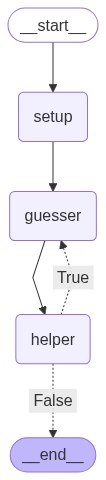

In [45]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [46]:
result = app.invoke({"player_name": "B", "guesses": [], "attempts": 0, "lower_bound": 1, "upper_bound": 20})

Welcome B, I have randomly selected a number between 1 and 20.
Attempt 1 (Current range: 1-20). I guess the number is 4. 
Too low! Try a higher number.
CONTINUING: 1/7 attempts used
Attempt 2 (Current range: 5-20). I guess the number is 13. 
Too low! Try a higher number.
CONTINUING: 2/7 attempts used
Attempt 3 (Current range: 14-20). I guess the number is 20. 
Too high! Try a lower number.
CONTINUING: 3/7 attempts used
Attempt 4 (Current range: 14-19). I guess the number is 19. 
Too high! Try a lower number.
CONTINUING: 4/7 attempts used
Attempt 5 (Current range: 14-18). I guess the number is 15. 
Too high! Try a lower number.
CONTINUING: 5/7 attempts used
Attempt 6 (Current range: 14-14). I guess the number is 14. 
Too high! Try a lower number.
YOU WIN! The number was: 14


In [47]:
result

{'player_name': 'B',
 'target_number': 14,
 'guesses': [4, 13, 20, 19, 15, 14],
 'attempts': 6,
 'hint': 'Too high! Try a lower number.',
 'lower_bound': 14,
 'upper_bound': 14,
 'max_attempts': 7}